In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
%matplotlib inline

# Summary Statistics

The Technology Select Sector SPDR® Fund seeks to provide investment results that, before expenses, correspond generally to the price and yield performance of the Technology Select Sector Index (the “Index”).

In [4]:
daily_returns = pd.read_csv('data/daily_log_returns_adj.csv', index_col=0, parse_dates=True)['AAPL']
daily_returns.describe()

count    7555.000000
mean        0.000805
std         0.027952
min        -0.731248
25%        -0.011924
50%         0.000481
75%         0.013832
max         0.286892
Name: AAPL, dtype: float64

In [5]:
print('Period: {} to {}'.format(daily_returns.index[0].strftime('%Y-%m-%d'), daily_returns.index[-1].strftime('%Y-%m-%d')))

Period: 1991-11-26 to 2021-11-23


<AxesSubplot:>

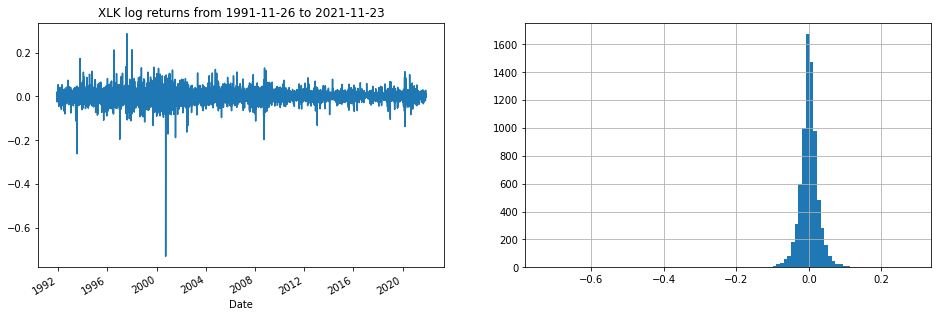

In [7]:
# Plot log returns and histogram
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
daily_returns.plot(ax=ax[0], title='XLK log returns from {} to {}'.format(daily_returns.index[0].strftime('%Y-%m-%d'), daily_returns.index[-1].strftime('%Y-%m-%d')))
daily_returns.hist(ax=ax[1], bins=100)

The returns appear to be unimodal, with a mean centered around zero. It looks like a normal distribution, but we should verify this through a test. The null hypothesis of `scipy.stats.normaltest` is that the sample comes from a normal distribution.

In [8]:
test_statistic, pvalue = st.normaltest(daily_returns)

print('Test statistic:', test_statistic)
print('P-value:', pvalue)

Test statistic: 5309.4193380639335
P-value: 0.0


Therefore, at $\alpha = 0.05$, we reject the null hypothesis that the log returns are normally distributed. This is likely due to the skew and kurtosis:

In [9]:
skew = st.skew(daily_returns)
kurtosis = st.kurtosis(daily_returns)

print('Skew:', skew)
print('Kurtosis:', kurtosis)

Skew: -2.2769923768813918
Kurtosis: 68.48637540663762


`scipy.kurtosis` returns the *excess* kurtosis over a normal distribution (which is 3).

# Autocorrelation function

A time series $\{r_t\}$ is *weakly stationary* if both the mean of $r_t$ and the covariance between $r_t$ and $r_{t-l}$ are time invariant, where $l$ is an arbitray integer. More specifically,
- $\mathbb{E}(r_t) = \mu$
- $Cov(r_t, r_{t-l}) = \gamma_l$

This means that the mean is constant, and $Cov(r_t, r_{t-l})$ only depends on $l$.

We can plot the autocorrelation function (ACF),

$$ \rho_l = \frac{Cov(r_t, r_{t-l})}{\sqrt{Var(r_t) Var(r_{t-l})}} = \frac{Cov(r_t, r_{t-l})}{Var(r_t)} = \frac{\gamma_l}{\gamma_0}$$

by using `statsmodels`. The y-axis represents the number of lags, $l$. The highlighted blue region represents the 5% (or 95% confidence) level of zero autocorrelation. The plot shows significant dependence on past values.

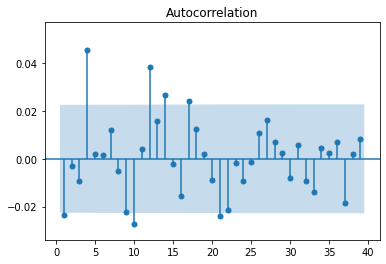

In [10]:
plot_acf(daily_returns, zero=False, auto_ylims=True)
plt.show()

Now we perform the Ljung-Box test, which tests for autocorrelation in the residuals (subtract the mean).

In [11]:
acorr_ljungbox(daily_returns)

,lb_stat,lb_pvalue
1,4.100100,0.042881
2,4.164529,0.124648
3,4.794778,0.187456
4,20.545340,0.000390
5,20.575239,0.000974
6,20.590177,0.002173
7,21.668181,0.002897
8,21.866437,0.005169
9,25.635414,0.002343
10,31.188905,0.000546


# Conditional Heteroscedasticity

What we are particularly interested in is the phenomena of clustering volatility. Take a rolling window of 252 days and calculating the volatility:

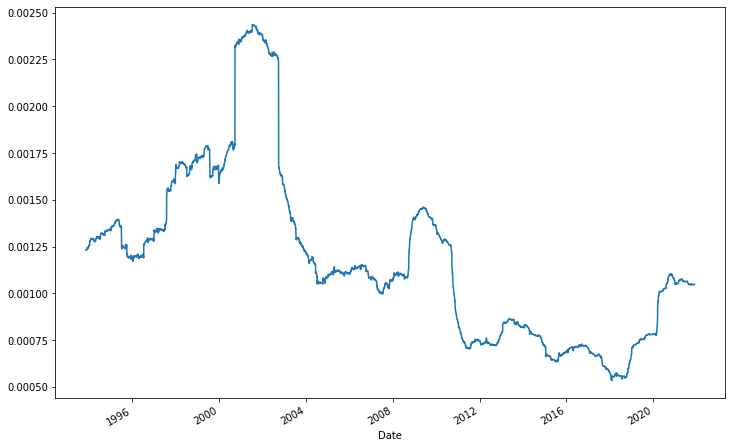

In [12]:
daily_vol = daily_returns.rolling(500).std() * np.sqrt(1 / (500 - 1))
daily_vol.plot(figsize=(12, 8))
plt.show()

This tends to be characterised by the partial autocorrelation function (PACF) of *squared* returns:

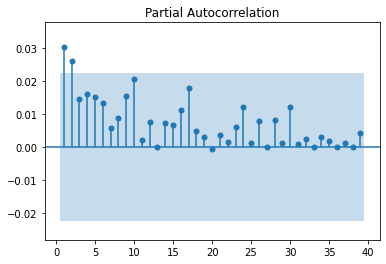

In [13]:
plot_pacf(daily_returns**2, zero=False, auto_ylims=True, method='ywm')
plt.show()

This most common conditional heteroscedasticity model is GARCH. Let's try fitting one with a normal distribution.

In [14]:
from arch.univariate import arch_model

model = arch_model(daily_returns, vol='garch', p=1, o=0, q=1, rescale=True)  # rescaling helps with convergence
res = model.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -17349.2
Distribution:                  Normal   AIC:                           34706.4
Method:            Maximum Likelihood   BIC:                           34734.2
                                        No. Observations:                 7555
Date:                Thu, Nov 25 2021   Df Residuals:                     7554
Time:                        11:45:04   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1827  2.833e-02      6.451  1.114e-10 [  0.127,  0.238]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0638  3.766e-02      1.695  9.013e-02 [-9.990e-03,  0.138]
alpha[1]       0.0889  3.956e-02      2.247  2.465e-02  [1.135e-02,  0.166]
beta[1]        0.9111  3.581e-02     25.444 8.235e-143    [  0.841,  0.981]
===========================================================================

Covariance estimator: robust
"""

In [15]:
# Forecasts can be performed with the fitted parameters:
forecast = res.forecast(horizon=10, reindex=False)
conditional_volatility = np.sqrt(forecast.variance / model.scale**2)

In [16]:
conditional_volatility  # 10-step-ahead forecast of volatility, annualised

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2021-11-23,0.014676,0.014892,0.015104,0.015314,0.015521,0.015726,0.015927,0.016126,0.016323,0.016517
